# Arboles de decision 

In [17]:
import numpy as np
import pandas as pd
import math
import ML_functions as ML
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler


df = pd.read_csv(r"C:\Users\ijtsi\Downloads\drug200.csv")
print(df.head())


   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY


In [2]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [3]:
print(df.isna().sum())
print(df.isna().sum().sum())

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64
0


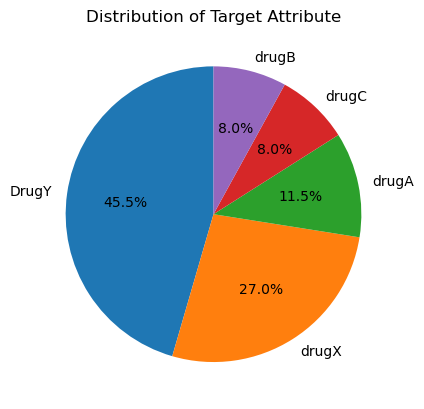

In [4]:
target_distribution = df['Drug'].value_counts()

# Create a pie chart
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Attribute')
plt.show()

In [5]:
# Specify the categorical features using their column indices
categorical_features = [1, 2, 3]  # indices of the categorical columns

# Initialize SMOTENC with the desired k-value and ratio

smote = SMOTENC(sampling_strategy = {
    "DrugY": 91, 
    "drugX": 75,  
    "drugA": 55, 
    "drugC": 35, 
    "drugB": 35   
}, categorical_features=categorical_features, k_neighbors=5)

# Perform SMOTE
X_resampled, y_resampled = smote.fit_resample(df.drop('Drug', axis=1), df['Drug'])

# Create a new DataFrame with the resampled data
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)


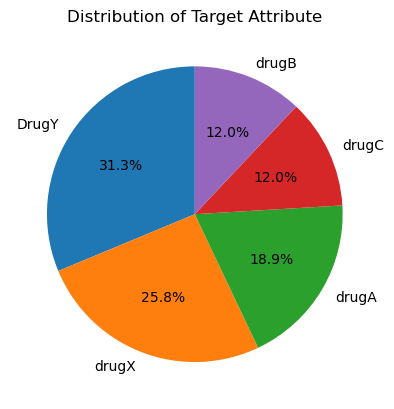

In [6]:
target_distribution = resampled_df['Drug'].value_counts()

# Create a pie chart
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Attribute')
plt.show()

In [7]:

def create_quartile_labels(df, attribute_name, new_attribute_name):
    """
    Calculate quartiles for a continuous attribute and create quartile labels.

    Parameters:
    - df: DataFrame containing the dataset.
    - attribute_name: Name of the continuous attribute.
    - new_attribute_name: Name of the new attribute to store quartile labels.

    Returns:
    - The DataFrame with the new quartile label attribute.
    """

    # Calculate quartiles
    quartiles = df[attribute_name].quantile([0.25, 0.5, 0.75])

    df[new_attribute_name] = pd.qcut(df[attribute_name], q=[0, 0.25, 0.5, 0.75, 1.0], labels=False)


    return df


In [8]:
data = resampled_df[['Na_to_K']]
scaler = StandardScaler()

# Fit the scaler on the data and transform it
resampled_df['Na_to_K_stand'] = scaler.fit_transform(data)


In [9]:
final= create_quartile_labels(resampled_df,"Na_to_K_stand", "NatoKIntervals")
final= create_quartile_labels(resampled_df,"Age", "AgeInterval")
final.drop(columns="Age",inplace=True)
final.drop(columns="Na_to_K",inplace=True)
final.drop(columns="Na_to_K_stand",inplace=True)
print(final.head())
print(final.info())

  Sex      BP Cholesterol   Drug  NatoKIntervals  AgeInterval
0   F    HIGH        HIGH  DrugY               3            0
1   M     LOW        HIGH  drugC               2            2
2   M     LOW        HIGH  drugC               0            2
3   F  NORMAL        HIGH  drugX               0            0
4   F     LOW        HIGH  DrugY               3            3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sex             291 non-null    object
 1   BP              291 non-null    object
 2   Cholesterol     291 non-null    object
 3   Drug            291 non-null    object
 4   NatoKIntervals  291 non-null    int64 
 5   AgeInterval     291 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 13.8+ KB
None


In [10]:
print(final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sex             291 non-null    object
 1   BP              291 non-null    object
 2   Cholesterol     291 non-null    object
 3   Drug            291 non-null    object
 4   NatoKIntervals  291 non-null    int64 
 5   AgeInterval     291 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 13.8+ KB
None


In [11]:
df_encoded= ML.cat_to_num(final)
print(df_encoded.head())
print(df_encoded.shape)

   Sex  BP  Cholesterol  Drug  NatoKIntervals  AgeInterval
0    0   0            0     0               3            0
1    1   1            0     1               2            2
2    1   1            0     1               0            2
3    0   2            0     2               0            0
4    0   1            0     0               3            3
(291, 6)


In [12]:

def calculate_entropy(data, target_column):
    """
    Calculate the entropy of a given dataset.
    Returns:
    The entropy of the dataset.
    """
    # Calculate the count of each unique class in the target column
    class_counts = data[target_column].value_counts()

    # Calculate the total number of instances
    total_instances = len(data)

    # Calculate the entropy
    entropy = 0
    for count in class_counts:
        probability = count / total_instances
        entropy -= probability * np.log2(probability)

    return entropy

def calculate_information_gain(data, attribute_column, target_column):
    """
    Calculate the information gain of a given attribute in a dataset.
    Returns:
    The information gain of the attribute.
    """
    # Calculate the entropy of the entire dataset
    total_entropy = calculate_entropy(data, target_column)

    # Calculate the unique values in the attribute column
    unique_values = data[attribute_column].unique()

    # Calculate the weighted sum of entropies for each value of the attribute
    weighted_entropy_sum = 0
    for value in unique_values:
        subset = data[data[attribute_column] == value]
        subset_entropy = calculate_entropy(subset, target_column)
        probability = len(subset) / len(data)
        weighted_entropy_sum += probability * subset_entropy

    # Calculate the information gain
    information_gain = total_entropy - weighted_entropy_sum

    return information_gain

In [13]:
import pandas as pd
from collections import Counter

def decision_tree(df, target_column, pred_df=None, pred_df_labels=None, max_depth=50):
    """
    Creates a Decision Tree from a DataFrame and optionally predicts labels for another DataFrame.
    Returns:
        Root node attribute
        Predicted labels for pred_df (if provided)
        Accuracy and confusion matrix (if pred_df and pred_df_labels are provided)
    """
    # Termination conditions for recursion
    if max_depth == 0 or len(df[target_column].unique()) == 1:
        majority_class = df[target_column].mode().iloc[0]
        return majority_class, None, None, None

    root_node, node_gain = find_best_split(df, target_column)
    
    # Split the dataset based on unique values of the root node attribute
    # Split the dataset based on unique values of the root node attribute
    branches = {}
    for attribute_value in df[root_node].unique():
        branch_data = df[df[root_node] == attribute_value]
        branches[attribute_value] = branch_data
      #  print(f"Data types in branches for attribute {root_node}: {branches[attribute_value].dtypes}")
      #  print(f"Unique values in branches for attribute {root_node}: {branches[attribute_value][root_node].unique()}")
       # print("Keys in branches dictionary:", branches.keys())

    
    # Create a dictionary to store the predicted labels
    predicted_labels = {}
    
    # Predict labels for pred_df if provided
    if pred_df is not None:
        for index, row in pred_df.iterrows():
            prediction = predict_labels(row, root_node, branches, target_column, max_depth)
            predicted_labels[index] = prediction
    
    # Calculate accuracy, confusion matrix, and other metrics if pred_df and pred_df_labels are provided
    accuracy = None
    num_classes = len(df[target_column].unique())
    class_labels = ["Drug Y", "Drug C", "Drug X", "Drug A", "Drug B"]
    
    if pred_df is not None and pred_df_labels is not None:
        true_labels = pred_df_labels.values
        predicted_values = [predicted_labels.get(index) for index in pred_df.index]
        

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predicted_values)

        # Calculate other metrics
        print("Classification Report:\n", classification_report(true_labels, predicted_values))

        # Calculate confusion matrix
        cm_data = [[Counter(zip(true_labels, predicted_values))[(true, pred)] for pred in range(num_classes)] for true in range(num_classes)]

        # Create a Seaborn heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()
    
    return root_node, predicted_labels, accuracy

def find_best_split(df, target_column):
    actual_gain = 0
    root_node = None
    node_gain = 0
    
    # Find the attribute with the highest information gain to be the root node
    for column in df.columns:
        if column != target_column:
            info_gain = calculate_information_gain(df, column, target_column)
            if info_gain > actual_gain:
                root_node = column
                node_gain = info_gain
            actual_gain = info_gain
    
    return root_node, node_gain



def predict_labels(data, root_node, branches, target_column, max_depth):
    if max_depth == 0 or root_node not in data:
        # Termination condition: Return the majority class if max depth is reached or root node is missing
        majority_class = branches[int(data[root_node])][target_column].mode().iloc[0]
        return majority_class
    
    # Get the attribute value from the data
    attribute_value = int(data[root_node])
    
    
    # Get the corresponding branch data
    branch_data = branches.get(attribute_value)
    
    if branch_data is None:
        # No data for this branch, return majority class
        majority_class = branches[int(data[root_node])][target_column].mode().iloc[0]
        return majority_class
    
    return predict_labels(data, root_node, branches, target_column, max_depth - 1)



In [14]:
# Splitting the DataFrame into 80% training and 20% testing
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)
print(test_df.head())
y_train= train_df["Drug"]
X_train = train_df.drop(columns=["Drug"])
y_test= test_df["Drug"]
X_test = test_df.drop(columns=["Drug"])

     Sex  BP  Cholesterol  Drug  NatoKIntervals  AgeInterval
84     0   1            0     1               0            2
259    1   1            0     1               1            1
45     0   2            1     2               0            3
176    1   0            1     3               1            2
143    1   0            1     0               2            3


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.00      0.00      0.00         5
           2       0.47      0.78      0.58        18
           3       0.50      0.58      0.54        12
           4       0.00      0.00      0.00         4

    accuracy                           0.61        59
   macro avg       0.39      0.42      0.40        59
weighted avg       0.58      0.61      0.58        59



A:\ijtsi\Program_files\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
A:\ijtsi\Program_files\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
A:\ijtsi\Program_files\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


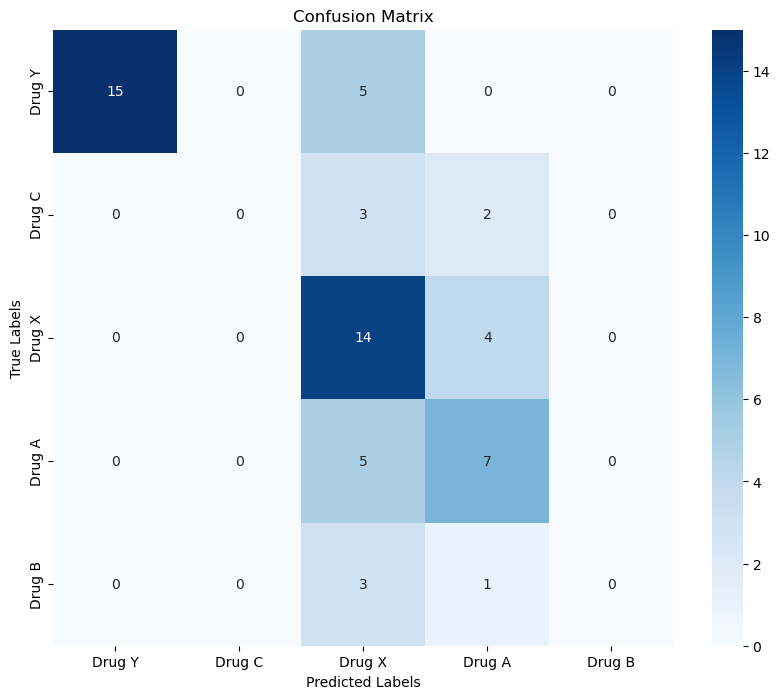

accuracy:  0.6101694915254238
<function confusion_matrix at 0x000001654B75A200>


In [15]:
root, predicted_labels, accuracy= decision_tree(train_df, "Drug", X_test, y_test)
print("accuracy: ", accuracy)
print(confusion_matrix)

Accuracy: 0.8813559322033898
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       1.00      1.00      1.00         5
           2       0.88      0.83      0.86        18
           3       1.00      0.92      0.96        12
           4       0.80      1.00      0.89         4

    accuracy                           0.88        59
   macro avg       0.90      0.92      0.91        59
weighted avg       0.89      0.88      0.88        59



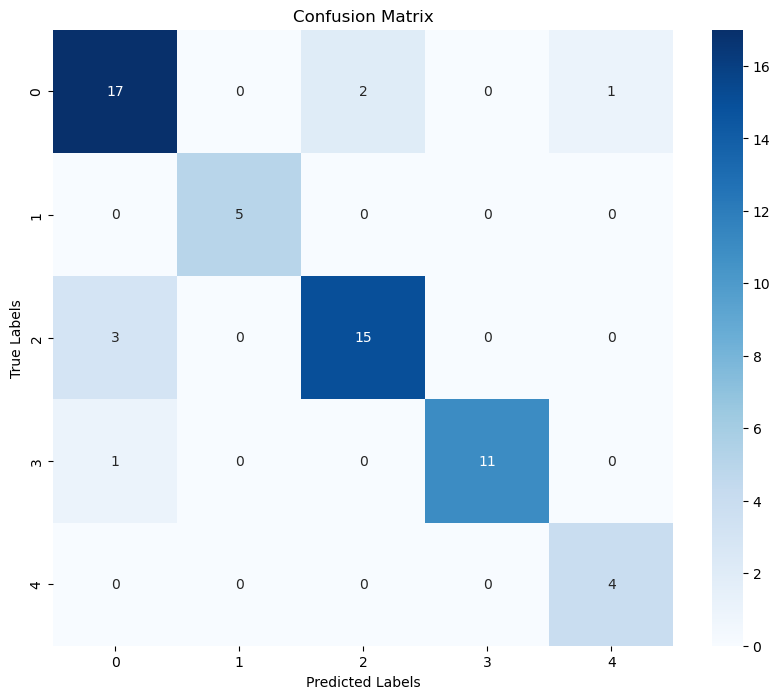

In [16]:

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))

# Calculate and plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()